# Draft of EKF implementation for temporal alignment

Using CTRA model.

Heavily based on [balzer82 implementation](https://github.com/balzer82/Kalman/blob/master/Extended-Kalman-Filter-CTRA.ipynb) and [giovannix adaptation](https://github.com/giovannix/kalman/blob/master/Extended-Kalman-Filter-CTRA.ipynb).

In [1]:
from sympy import symbols, Matrix, init_printing
from IPython.display import display

init_printing()

vs, psis, dpsis, dts, xs, ys, lats, lons, axs = symbols('v \psi \dot\psi T x y lat lon a')

hs = Matrix([[xs],
             [ys],
             [psis],
             [vs],
             [dpsis],
             [axs]])

state = Matrix([xs,ys,psis,vs,dpsis,axs])

# Preallocation for Plotting
x0 = []
x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
x6 = []
Zx = []
Zy = []
Px = []
Py = []
Pdx= []
Pdy= []
Pddx=[]
Pddy=[]
Pdv =[]
Kx = []
Ky = []
Kdx= []
Kdy= []
Kddx=[]
Kdv= []
dstate=[]

In [2]:
def log_state_and_noises(iteration, state, noises):
    state_s, noise_s, sensors_std_s, measurement_s = symbols('state noise sensors\_std measurement')
    
    print(f'Iteration {iteration}:')
    print('='*100)
    display(Eq(state_s, measurement_s + noise_s))
    display(Eq(
        state_s,
        Eq(state, Matrix(x), evaluate=False)
    ))

    display(Eq(
        Le(
            -sensors_std_s,
            Le(noise_s, sensors_std_s),
            evaluate=False
        ),
        Le(
            Matrix(-sensors_std),
            Le(Matrix(noises), Matrix(sensors_std), evaluate=False),
            evaluate=False
        )
    ))
    print('='*100)

In [3]:
import numpy as np
from numpy.random import default_rng
from sympy import Matrix, Eq, Le, Ge, symbols, init_printing
from IPython.display import display

init_printing()

STATE_SIZE = 6 # States
STATE_X_IDX, STATE_Y_IDX, STATE_YAW_IDX, STATE_VELOCITY_IDX, STATE_YAW_RATE_IDX, STATE_ACCELERATION_IDX = range(STATE_SIZE)

# Generated running the loop with correction commented, just with prediction
mock = np.array([
    # Generated with x = [10, 10, np.pi/2, 5, np.pi/10, 5]
    [9.99162312, 10.52491159, 1.60221225, 5.5, 0.31415927, 5.],
    [9.96440727, 11.09924348, 1.63362818, 6. , 0.31415927, 5.],
    [9.91524186, 11.72228092, 1.66504411, 6.5, 0.31415927, 5.],

    # Generated with x = [9.84104414, 12.39316261, 1.69646003, 7 , 0, 2]
    [9.84104414, 12.39316261, 1.69646003, 7 , 0, 2],
    [9.75205920946478, 13.097565812433922, 1.69646103, 7.2, 1e-05, 2.0],
    [9.660566840228446, 13.821813141209995, 1.6964620300000002, 7.4, 1e-05, 2.0],

    # Generated with x = [9.660566840228446, 13.821813141209995, 1.6964620300000002, 7.4, -np.pi/5, 0.5]
    [9.660566840228446, 13.821813141209995, 1.6964620300000002, 7.4, -np.pi/5, 0.5],
    [9.590727496248219, 14.560898635653817, 1.6336301769282038, 7.45, -0.6283185307179586, 0.5],

    # Generated with x = [9.546139274244736, 15.269496260674774, 1.633631176928204, 6.75, 1e-05, -7.0]
    [9.546139274244736, 15.269496260674774, 1.633631176928204, 6.75, 1e-05, -7.0],
    [9.505945314972719, 15.90822977120212, 1.633632176928204, 6.05, 1e-05, -7.0],
    [9.470145618432168, 16.47710804902005, 1.6336331769282042, 5.35, 1e-05, -7.0],
])

def predict(x, P, Q, dt):
    if np.abs(x[STATE_YAW_RATE_IDX]) < 0.00001: # Driving straight
        x[STATE_YAW_RATE_IDX] = 0.00001

    x[STATE_X_IDX] = x[STATE_X_IDX] + (1 / x[STATE_YAW_RATE_IDX]**2) * \
        ( \
            (x[STATE_VELOCITY_IDX]*x[STATE_YAW_RATE_IDX] + x[STATE_ACCELERATION_IDX] * x[STATE_YAW_RATE_IDX] * dt) * np.sin(x[STATE_YAW_IDX] + x[STATE_YAW_RATE_IDX]* dt) \
            + x[STATE_ACCELERATION_IDX] * np.cos(x[STATE_YAW_IDX] + x[STATE_YAW_RATE_IDX] * dt) \
            - x[STATE_VELOCITY_IDX] * x[STATE_YAW_RATE_IDX] * np.sin(x[STATE_YAW_IDX]) - x[STATE_ACCELERATION_IDX] * np.cos(x[STATE_YAW_IDX]) \
        )

    x[STATE_Y_IDX] = x[STATE_Y_IDX] + (1 / x[STATE_YAW_RATE_IDX]**2) * \
        ( \
            (-x[STATE_VELOCITY_IDX]*x[STATE_YAW_RATE_IDX] - x[STATE_ACCELERATION_IDX] * x[STATE_YAW_RATE_IDX] * dt) * np.cos(x[STATE_YAW_IDX] + x[STATE_YAW_RATE_IDX]* dt) \
            + x[STATE_ACCELERATION_IDX] * np.sin(x[STATE_YAW_IDX] + x[STATE_YAW_RATE_IDX] * dt) \
            + x[STATE_VELOCITY_IDX] * x[STATE_YAW_RATE_IDX] * np.cos(x[STATE_YAW_IDX]) - x[STATE_ACCELERATION_IDX] * np.sin(x[STATE_YAW_IDX]) \
        )

    x[STATE_YAW_IDX] = (x[STATE_YAW_IDX] + x[STATE_YAW_RATE_IDX] * dt + np.pi) % (2.0 * np.pi) - np.pi
    x[STATE_VELOCITY_IDX] = x[STATE_VELOCITY_IDX] + x[STATE_ACCELERATION_IDX] * dt 
    x[STATE_YAW_RATE_IDX] = x[STATE_YAW_RATE_IDX]
    x[STATE_ACCELERATION_IDX] = x[STATE_ACCELERATION_IDX]

    # Calculate the Jacobian of the Dynamic Matrix A
    a13 = ( \
      (-x[STATE_YAW_RATE_IDX]*x[STATE_VELOCITY_IDX]*np.cos(x[STATE_YAW_IDX]) + x[STATE_ACCELERATION_IDX]*np.sin(x[STATE_YAW_IDX]) \
      - x[STATE_ACCELERATION_IDX]*np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) + (dt*x[STATE_YAW_RATE_IDX]*x[STATE_ACCELERATION_IDX] + x[STATE_YAW_RATE_IDX]*x[STATE_VELOCITY_IDX])*np.cos(dt*x[STATE_YAW_RATE_IDX] \
      + x[STATE_YAW_IDX]))/x[STATE_YAW_RATE_IDX]**2 \
    ).item(0)

    a14 = ( \
      (-x[STATE_YAW_RATE_IDX]*np.sin(x[STATE_YAW_IDX]) + x[STATE_YAW_RATE_IDX]*np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]))/x[STATE_YAW_RATE_IDX]**2 \
    ).item(0)

    a15 = ( \
      ( \
        -dt*x[STATE_ACCELERATION_IDX]*np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) + dt*(dt*x[STATE_YAW_RATE_IDX]*x[STATE_ACCELERATION_IDX] + x[STATE_YAW_RATE_IDX]*x[STATE_VELOCITY_IDX]) \
        * np.cos(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) - x[STATE_VELOCITY_IDX]*np.sin(x[STATE_YAW_IDX]) + (dt*x[STATE_ACCELERATION_IDX] + x[STATE_VELOCITY_IDX]) \
        * np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) \
      ) / x[STATE_YAW_RATE_IDX]**2 \
      - 2*( \
        -x[STATE_YAW_RATE_IDX]*x[STATE_VELOCITY_IDX]*np.sin(x[STATE_YAW_IDX]) - x[STATE_ACCELERATION_IDX] \
        * np.cos(x[STATE_YAW_IDX]) + x[STATE_ACCELERATION_IDX]*np.cos(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) + (dt*x[STATE_YAW_RATE_IDX]*x[STATE_ACCELERATION_IDX] + x[STATE_YAW_RATE_IDX]*x[STATE_VELOCITY_IDX]) \
        * np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) \
      ) / x[STATE_YAW_RATE_IDX]**3 \
    ).item(0)

    a16 = ( \
      (dt*x[STATE_YAW_RATE_IDX]*np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) - np.cos(x[STATE_YAW_IDX]) + np.cos(dt * x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]))/x[STATE_YAW_RATE_IDX]**2 \
    ).item(0)

    a23 = ( \
      ( \
        -x[STATE_YAW_RATE_IDX] * x[STATE_VELOCITY_IDX] * np.sin(x[STATE_YAW_IDX]) - x[STATE_ACCELERATION_IDX] * np.cos(x[STATE_YAW_IDX]) + x[STATE_ACCELERATION_IDX] * np.cos(dt * x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) \
        - (-dt * x[STATE_YAW_RATE_IDX]*x[STATE_ACCELERATION_IDX] - x[STATE_YAW_RATE_IDX] * x[STATE_VELOCITY_IDX]) * np.sin(dt * x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) \
      ) / x[STATE_YAW_RATE_IDX]**2 \
    ).item(0)

    a24 = ( \
      (x[STATE_YAW_RATE_IDX] * np.cos(x[STATE_YAW_IDX]) - x[STATE_YAW_RATE_IDX]*np.cos(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]))/x[STATE_YAW_RATE_IDX]**2 \
    ).item(0)

    a25 = ( \
      ( \
        dt * x[STATE_ACCELERATION_IDX]*np.cos(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) - dt * (-dt*x[STATE_YAW_RATE_IDX]*x[STATE_ACCELERATION_IDX] - x[STATE_YAW_RATE_IDX] * x[STATE_VELOCITY_IDX]) \
        * np.sin(dt * x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) + x[STATE_VELOCITY_IDX]*np.cos(x[STATE_YAW_IDX]) + (-dt*x[STATE_ACCELERATION_IDX] - x[STATE_VELOCITY_IDX])*np.cos(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) \
      ) / x[STATE_YAW_RATE_IDX]**2 \
      - 2*( \
        x[STATE_YAW_RATE_IDX]*x[STATE_VELOCITY_IDX]*np.cos(x[STATE_YAW_IDX]) - x[STATE_ACCELERATION_IDX] * np.sin(x[STATE_YAW_IDX]) + x[STATE_ACCELERATION_IDX] * np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) \
        + (-dt * x[STATE_YAW_RATE_IDX] * x[STATE_ACCELERATION_IDX] - x[STATE_YAW_RATE_IDX] * x[STATE_VELOCITY_IDX])*np.cos(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) \
      ) / x[STATE_YAW_RATE_IDX]**3 \
    ).item(0)

    a26 = ( \
      (-dt*x[STATE_YAW_RATE_IDX]*np.cos(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) - np.sin(x[STATE_YAW_IDX]) + np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]))/x[STATE_YAW_RATE_IDX]**2 \
    ).item(0)
      
    JA = np.matrix([[1.0, 0.0, a13, a14, a15, a16],
                    [0.0, 1.0, a23, a24, a25, a26],
                    [0.0, 0.0, 1.0, 0.0, dt, 0.0],
                    [0.0, 0.0, 0.0, 1.0, 0.0, dt],
                    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
  
    # Project the error covariance ahead
    P = JA*P*JA.T + Q

    return x, P


def correct(measurement, x, P, R):
    hx = x.copy()  # Not making any transformation and considering all the atributes are being measured

    # Indentity because is assumed that for each attribute in state there exists a respective measurement attribute
    JH = np.eye(hx.shape[0])

    S = JH*P*JH.T + R
    K = (P*JH.T) * np.linalg.inv(S)

    # Update the estimate via
    Z = measurement.reshape(JH.shape[0], 1)
    y = Z - hx  # Innovation or Residual
    x = x + K*y

    # Update the error covariance
    P = (np.eye(STATE_SIZE) - K*JH)*P
            
    # TODO: Remove in main C++ code
    x0.append(float(x[0]))
    x1.append(float(x[1]))
    x2.append(float(x[2]))
    x3.append(float(x[3]))
    x4.append(float(x[4]))
    x5.append(float(x[5]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))    
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Pddx.append(float(P[4,4]))
    Pdv.append(float(P[5,5]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))
    Kddx.append(float(K[4,0]))
    Kdv.append(float(K[5,0]))

    return x, P


if __name__ == '__main__':
    P = np.diag([10.0, 10.0, 10.0, 10.0, 10.0, 10.0])

    dt = 1/10

    variance_gps     = 0.5*8.8*dt**2  # assume 8.8m/s2 as maximum acceleration, forcing the vehicle
    variance_course  = 0.1*dt # assume 0.1rad/s as maximum turn rate for the vehicle
    variance_velocity= 8.8*dt # assume 8.8m/s2 as maximum acceleration, forcing the vehicle
    variance_yawrate = 1.0*dt # assume 1.0rad/s2 as the maximum turn rate acceleration for the vehicle
    variance_accel   = 0.5 # assume 0.5m/s2

    # TODO: Can be improved and calibratred
    Q = np.diag([variance_gps**2, variance_gps**2, variance_course**2, variance_velocity**2, variance_yawrate**2, variance_accel**2])
    
    std_gps = 0.1 # standard deviation of gps measurement
    std_speed = 3.0 # standard deviation of the speed measurement
    std_yawrate = 0.1 # standard deviation of the yawrate measurement
    std_yaw = 0.01 # standard deviation of the yaw measurement
    std_acc = 1.0 # standard deviation of the longitudinal acceleration

    R = np.diag([std_gps**2, std_gps**2, std_yaw**2, std_speed**2, std_yawrate**2, std_acc**2])


    inital_x, initial_y = 10, 10
    yaw = np.pi/2
    speed = 12
    yaw_rate = np.pi/10
    acc = 5

    x = np.array([[inital_x, initial_y, yaw, speed, yaw_rate, acc]], dtype='float64').T
    
    random_generator = default_rng()

    for i, measurement in enumerate(mock, 1):
        sensors_std = np.array([std_gps, std_gps, std_yaw, std_speed, std_yawrate, std_acc])
        
        # Adding noise
        noises = (random_generator.random() for _ in sensors_std)
        noises = np.array([n * 2*std - std for std, n in zip(sensors_std, noises)])  # Putting noises in std range
        measurement += noises
        
        x, P = predict(x, P, Q, dt)        
        x, P = correct(measurement, x, P, R)

        log_state_and_noises(i, state, noises)


Iteration 1:


        ⎡   x    ⎤   ⎡ 9.9518462926435 ⎤
        ⎢        ⎥   ⎢                 ⎥
        ⎢   y    ⎥   ⎢10.5530143443817 ⎥
        ⎢        ⎥   ⎢                 ⎥
        ⎢  \psi  ⎥   ⎢1.60170915466012 ⎥
state = ⎢        ⎥ = ⎢                 ⎥
        ⎢   v    ⎥   ⎢8.63309817299014 ⎥
        ⎢        ⎥   ⎢                 ⎥
        ⎢\dot\psi⎥   ⎢0.327781721034681⎥
        ⎢        ⎥   ⎢                 ⎥
        ⎣   a    ⎦   ⎣5.14125944573808 ⎦

                                       ⎡-0.1 ⎤   ⎡ -0.0398240397329281 ⎤   ⎡0.
                                       ⎢     ⎥   ⎢                     ⎥   ⎢  
                                       ⎢-0.1 ⎥   ⎢  0.027790225023657  ⎥   ⎢0.
                                       ⎢     ⎥   ⎢                     ⎥   ⎢  
                                       ⎢-0.01⎥   ⎢-0.000503903337859202⎥   ⎢0.
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                     ⎥ ≤ ⎢  
                                       ⎢-3.0 ⎥   ⎢ -0.0818671776187041 ⎥   ⎢3.
                                       ⎢     ⎥   ⎢                     ⎥   ⎢  
                                       ⎢-0.1 ⎥   ⎢ 0.0136400597682193  ⎥   ⎢0.
                                       ⎢     ⎥   ⎢                     ⎥   ⎢  
                                       ⎣-1.0 ⎦   ⎣  0.19004246293668   ⎦   ⎣1.

1 ⎤
  ⎥
1 ⎥
  ⎥
01⎥
  ⎥
0 ⎥
  ⎥
1 ⎥
  ⎥
0 ⎦

Iteration 2:


        ⎡   x    ⎤   ⎡9.99896431183282 ⎤
        ⎢        ⎥   ⎢                 ⎥
        ⎢   y    ⎥   ⎢11.1632807238634 ⎥
        ⎢        ⎥   ⎢                 ⎥
        ⎢  \psi  ⎥   ⎢1.63856995202915 ⎥
state = ⎢        ⎥ = ⎢                 ⎥
        ⎢   v    ⎥   ⎢6.53288148516703 ⎥
        ⎢        ⎥   ⎢                 ⎥
        ⎢\dot\psi⎥   ⎢0.366116230133148⎥
        ⎢        ⎥   ⎢                 ⎥
        ⎣   a    ⎦   ⎣5.49940407533175 ⎦

                                       ⎡-0.1 ⎤   ⎡0.0942556839301166 ⎤   ⎡0.1 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.1 ⎥   ⎢0.0379660380205364 ⎥   ⎢0.1 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.01⎥   ⎢0.00607912572754112⎥   ⎢0.01
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                   ⎥ ≤ ⎢    
                                       ⎢-3.0 ⎥   ⎢ -1.29577251291806 ⎥   ⎢3.0 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.1 ⎥   ⎢0.0668056826520064 ⎥   ⎢0.1 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎣-1.0 ⎦   ⎣ 0.853888279927018 ⎦   ⎣1.0 

⎤
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎦

Iteration 3:


        ⎡   x    ⎤   ⎡9.97569056382751 ⎤
        ⎢        ⎥   ⎢                 ⎥
        ⎢   y    ⎥   ⎢11.7378871988011 ⎥
        ⎢        ⎥   ⎢                 ⎥
        ⎢  \psi  ⎥   ⎢1.67082348986042 ⎥
state = ⎢        ⎥ = ⎢                 ⎥
        ⎢   v    ⎥   ⎢6.44033787565458 ⎥
        ⎢        ⎥   ⎢                 ⎥
        ⎢\dot\psi⎥   ⎢0.362555474318006⎥
        ⎢        ⎥   ⎢                 ⎥
        ⎣   a    ⎦   ⎣5.48747415247821 ⎦

                                       ⎡-0.1 ⎤   ⎡ 0.0927761573731089 ⎤   ⎡0.1
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.1 ⎥   ⎢-0.00832445998995339⎥   ⎢0.1
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.01⎥   ⎢0.00400827023909056 ⎥   ⎢0.0
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                    ⎥ ≤ ⎢   
                                       ⎢-3.0 ⎥   ⎢-0.0242676463484273 ⎥   ⎢3.0
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.1 ⎥   ⎢ 0.0546658409110194 ⎥   ⎢0.1
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎣-1.0 ⎦   ⎣  0.49201625118626  ⎦   ⎣1.0

 ⎤
 ⎥
 ⎥
 ⎥
1⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎦

Iteration 4:


        ⎡   x    ⎤   ⎡9.86456811636119 ⎤
        ⎢        ⎥   ⎢                 ⎥
        ⎢   y    ⎥   ⎢12.4384665924435 ⎥
        ⎢        ⎥   ⎢                 ⎥
        ⎢  \psi  ⎥   ⎢1.69561677544409 ⎥
state = ⎢        ⎥ = ⎢                 ⎥
        ⎢   v    ⎥   ⎢6.82097749538071 ⎥
        ⎢        ⎥   ⎢                 ⎥
        ⎢\dot\psi⎥   ⎢0.127693653802351⎥
        ⎢        ⎥   ⎢                 ⎥
        ⎣   a    ⎦   ⎣3.72265697073559 ⎦

                                       ⎡-0.1 ⎤   ⎡-0.0317323923770035 ⎤   ⎡0.1
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.1 ⎥   ⎢ 0.067996892148574  ⎥   ⎢0.1
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.01⎥   ⎢-0.00172379862007372⎥   ⎢0.0
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                    ⎥ ≤ ⎢   
                                       ⎢-3.0 ⎥   ⎢ -2.38776230208445  ⎥   ⎢3.0
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.1 ⎥   ⎢ -0.016510942221565 ⎥   ⎢0.1
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎣-1.0 ⎦   ⎣ -0.833730503480996 ⎦   ⎣1.0

 ⎤
 ⎥
 ⎥
 ⎥
1⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎦

Iteration 5:


        ⎡   x    ⎤   ⎡ 9.75206430057718 ⎤
        ⎢        ⎥   ⎢                  ⎥
        ⎢   y    ⎥   ⎢ 13.0657583677175 ⎥
        ⎢        ⎥   ⎢                  ⎥
        ⎢  \psi  ⎥   ⎢ 1.69922435806144 ⎥
state = ⎢        ⎥ = ⎢                  ⎥
        ⎢   v    ⎥   ⎢ 6.80404339175784 ⎥
        ⎢        ⎥   ⎢                  ⎥
        ⎢\dot\psi⎥   ⎢0.0982061152669809⎥
        ⎢        ⎥   ⎢                  ⎥
        ⎣   a    ⎦   ⎣ 3.30989092858582 ⎦

                                       ⎡-0.1 ⎤   ⎡ -0.055113448428988 ⎤   ⎡0.1
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.1 ⎥   ⎢-0.0604763195969654 ⎥   ⎢0.1
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.01⎥   ⎢-0.00113711640949252⎥   ⎢0.0
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                    ⎥ ≤ ⎢   
                                       ⎢-3.0 ⎥   ⎢ -0.562270000216825 ⎥   ⎢3.0
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.1 ⎥   ⎢ 0.0950574182960058 ⎥   ⎢0.1
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎣-1.0 ⎦   ⎣ 0.700154349753178  ⎦   ⎣1.0

 ⎤
 ⎥
 ⎥
 ⎥
1⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎦

Iteration 6:


        ⎡   x    ⎤   ⎡ 9.65599134687549 ⎤
        ⎢        ⎥   ⎢                  ⎥
        ⎢   y    ⎥   ⎢ 13.7350360149432 ⎥
        ⎢        ⎥   ⎢                  ⎥
        ⎢  \psi  ⎥   ⎢ 1.69945277847757 ⎥
state = ⎢        ⎥ = ⎢                  ⎥
        ⎢   v    ⎥   ⎢ 6.87790820256345 ⎥
        ⎢        ⎥   ⎢                  ⎥
        ⎢\dot\psi⎥   ⎢0.0568687827163909⎥
        ⎢        ⎥   ⎢                  ⎥
        ⎣   a    ⎦   ⎣ 2.44235035936633 ⎦

                                       ⎡-0.1 ⎤   ⎡ -0.0228727629283378 ⎤   ⎡0.
                                       ⎢     ⎥   ⎢                     ⎥   ⎢  
                                       ⎢-0.1 ⎥   ⎢ -0.0897812375611379 ⎥   ⎢0.
                                       ⎢     ⎥   ⎢                     ⎥   ⎢  
                                       ⎢-0.01⎥   ⎢-0.000714871686527447⎥   ⎢0.
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                     ⎥ ≤ ⎢  
                                       ⎢-3.0 ⎥   ⎢  -1.29749611600947  ⎥   ⎢3.
                                       ⎢     ⎥   ⎢                     ⎥   ⎢  
                                       ⎢-0.1 ⎥   ⎢ 0.0462213090242675  ⎥   ⎢0.
                                       ⎢     ⎥   ⎢                     ⎥   ⎢  
                                       ⎣-1.0 ⎦   ⎣ -0.890823776784139  ⎦   ⎣1.

1 ⎤
  ⎥
1 ⎥
  ⎥
01⎥
  ⎥
0 ⎥
  ⎥
1 ⎥
  ⎥
0 ⎦

Iteration 7:


        ⎡   x    ⎤   ⎡ 9.6521138313812  ⎤
        ⎢        ⎥   ⎢                  ⎥
        ⎢   y    ⎥   ⎢ 13.9610464346332 ⎥
        ⎢        ⎥   ⎢                  ⎥
        ⎢  \psi  ⎥   ⎢ 1.68995996591463 ⎥
state = ⎢        ⎥ = ⎢                  ⎥
        ⎢   v    ⎥   ⎢ 5.12269888220604 ⎥
        ⎢        ⎥   ⎢                  ⎥
        ⎢\dot\psi⎥   ⎢-0.369254007969745⎥
        ⎢        ⎥   ⎢                  ⎥
        ⎣   a    ⎦   ⎣ 1.55869137187754 ⎦

                                       ⎡-0.1 ⎤   ⎡ 0.0462163910220594 ⎤   ⎡0.1
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.1 ⎥   ⎢-0.0554294821278288 ⎥   ⎢0.1
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.01⎥   ⎢-0.00508753888901712⎥   ⎢0.0
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                    ⎥ ≤ ⎢   
                                       ⎢-3.0 ⎥   ⎢  2.90927911581377  ⎥   ⎢3.0
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.1 ⎥   ⎢-0.0137431609113086 ⎥   ⎢0.1
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎣-1.0 ⎦   ⎣ -0.218448106448931 ⎦   ⎣1.0

 ⎤
 ⎥
 ⎥
 ⎥
1⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎦

Iteration 8:


        ⎡   x    ⎤   ⎡ 9.60188367095635 ⎤
        ⎢        ⎥   ⎢                  ⎥
        ⎢   y    ⎥   ⎢ 14.5824422247367 ⎥
        ⎢        ⎥   ⎢                  ⎥
        ⎢  \psi  ⎥   ⎢ 1.63218895817851 ⎥
state = ⎢        ⎥ = ⎢                  ⎥
        ⎢   v    ⎥   ⎢ 6.31196608468125 ⎥
        ⎢        ⎥   ⎢                  ⎥
        ⎢\dot\psi⎥   ⎢-0.557746999359111⎥
        ⎢        ⎥   ⎢                  ⎥
        ⎣   a    ⎦   ⎣ 1.54212391302372 ⎦

                                       ⎡-0.1 ⎤   ⎡ 0.0166072383464808 ⎤   ⎡0.1
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.1 ⎥   ⎢ 0.0364895009574537 ⎥   ⎢0.1
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.01⎥   ⎢-0.00737944145163043⎥   ⎢0.0
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                    ⎥ ≤ ⎢   
                                       ⎢-3.0 ⎥   ⎢  2.65092184000928  ⎥   ⎢3.0
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.1 ⎥   ⎢-0.0225178498061711 ⎥   ⎢0.1
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎣-1.0 ⎦   ⎣ 0.964870725982973  ⎦   ⎣1.0

 ⎤
 ⎥
 ⎥
 ⎥
1⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎦

Iteration 9:


        ⎡   x    ⎤   ⎡ 9.52189851419167 ⎤
        ⎢        ⎥   ⎢                  ⎥
        ⎢   y    ⎥   ⎢ 15.2807621346244 ⎥
        ⎢        ⎥   ⎢                  ⎥
        ⎢  \psi  ⎥   ⎢ 1.61873585363835 ⎥
state = ⎢        ⎥ = ⎢                  ⎥
        ⎢   v    ⎥   ⎢ 6.75548707761153 ⎥
        ⎢        ⎥   ⎢                  ⎥
        ⎢\dot\psi⎥   ⎢-0.177696502577887⎥
        ⎢        ⎥   ⎢                  ⎥
        ⎣   a    ⎦   ⎣-1.71970683170387 ⎦

                                       ⎡-0.1 ⎤   ⎡-0.0996969456538982 ⎤   ⎡0.1
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.1 ⎥   ⎢ 0.0337499982017404 ⎥   ⎢0.1
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.01⎥   ⎢-0.00301724804886256⎥   ⎢0.0
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                    ⎥ ≤ ⎢   
                                       ⎢-3.0 ⎥   ⎢  1.22180859275472  ⎥   ⎢3.0
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.1 ⎥   ⎢0.00930530701682437 ⎥   ⎢0.1
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎣-1.0 ⎦   ⎣ 0.156601666539083  ⎦   ⎣1.0

 ⎤
 ⎥
 ⎥
 ⎥
1⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎦

Iteration 10:


        ⎡   x    ⎤   ⎡  9.50706948575839  ⎤
        ⎢        ⎥   ⎢                    ⎥
        ⎢   y    ⎥   ⎢  15.8781291110254  ⎥
        ⎢        ⎥   ⎢                    ⎥
        ⎢  \psi  ⎥   ⎢  1.62197134294159  ⎥
state = ⎢        ⎥ = ⎢                    ⎥
        ⎢   v    ⎥   ⎢  6.12717275262149  ⎥
        ⎢        ⎥   ⎢                    ⎥
        ⎢\dot\psi⎥   ⎢-0.00292474606371626⎥
        ⎢        ⎥   ⎢                    ⎥
        ⎣   a    ⎦   ⎣ -3.85779170079678  ⎦

                                       ⎡-0.1 ⎤   ⎡ 0.0344247224693224 ⎤   ⎡0.1
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.1 ⎥   ⎢-0.0505213164701512 ⎥   ⎢0.1
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.01⎥   ⎢-0.00523843463879951⎥   ⎢0.0
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                    ⎥ ≤ ⎢   
                                       ⎢-3.0 ⎥   ⎢ 0.370394716003501  ⎥   ⎢3.0
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.1 ⎥   ⎢ 0.0801454723292205 ⎥   ⎢0.1
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎣-1.0 ⎦   ⎣ -0.185763789390367 ⎦   ⎣1.0

 ⎤
 ⎥
 ⎥
 ⎥
1⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎦

Iteration 11:


        ⎡   x    ⎤   ⎡  9.4654886308845  ⎤
        ⎢        ⎥   ⎢                   ⎥
        ⎢   y    ⎥   ⎢ 16.4243332653641  ⎥
        ⎢        ⎥   ⎢                   ⎥
        ⎢  \psi  ⎥   ⎢ 1.63151616628965  ⎥
state = ⎢        ⎥ = ⎢                   ⎥
        ⎢   v    ⎥   ⎢ 5.47947322631559  ⎥
        ⎢        ⎥   ⎢                   ⎥
        ⎢\dot\psi⎥   ⎢-0.0272789542460383⎥
        ⎢        ⎥   ⎢                   ⎥
        ⎣   a    ⎦   ⎣  -5.429334703431  ⎦

                                       ⎡-0.1 ⎤   ⎡-0.0220022322606685⎤   ⎡0.1 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.1 ⎥   ⎢-0.0693197942413132⎥   ⎢0.1 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.01⎥   ⎢0.00285011415812405⎥   ⎢0.01
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                   ⎥ ≤ ⎢    
                                       ⎢-3.0 ⎥   ⎢ 0.720424744177626 ⎥   ⎢3.0 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.1 ⎥   ⎢-0.0638082655873679⎥   ⎢0.1 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎣-1.0 ⎦   ⎣-0.879333942888701 ⎦   ⎣1.0 

⎤
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎦

## Plots

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

m = len(mock)

### Kalman Gain

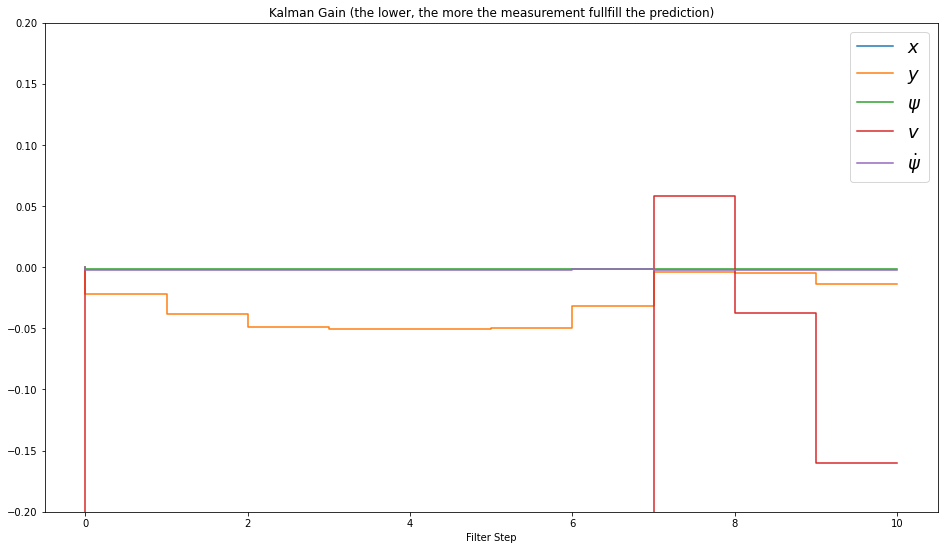

In [5]:
fig = plt.figure(figsize=(16,9))
plt.step(range(m),Kx, label='$x$')
plt.step(range(m),Ky, label='$y$')
plt.step(range(m),Kdx, label='$\psi$')
plt.step(range(m),Kdy, label='$v$')
plt.step(range(m),Kddx, label='$\dot \psi$')


plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
plt.legend(prop={'size':18})
plt.ylim([-0.2,0.2]);

### Uncertainties

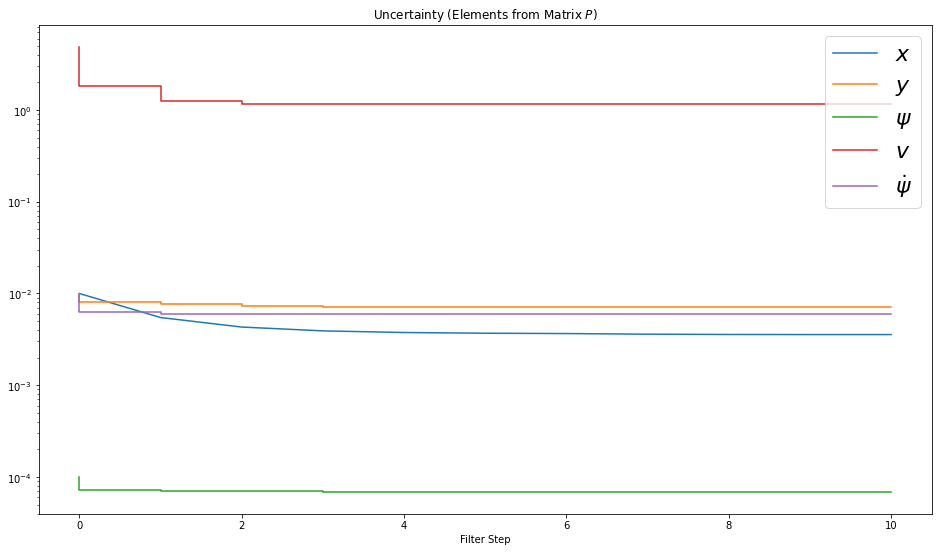

In [6]:

fig = plt.figure(figsize=(16,9))
plt.semilogy(range(m),Px, label='$x$')
plt.step(range(m),Py, label='$y$')
plt.step(range(m),Pdx, label='$\psi$')
plt.step(range(m),Pdy, label='$v$')
plt.step(range(m),Pddx, label='$\dot \psi$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Uncertainty (Elements from Matrix $P$)')
plt.legend(loc='best',prop={'size':22})

### Position x/y

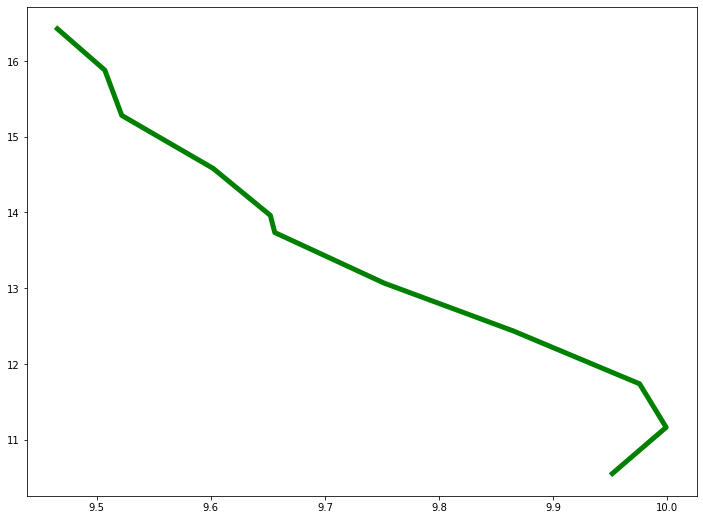

In [7]:
fig = plt.figure(figsize=(12,9))

plt.plot(x0,x1, label='EKF Position', c='g', lw=5)